# Introduction - Mask Detector Reproducible Notebook

This notebook represents our first effort at Kabam to adopt [the CCDS DSAIML framework](https://drivendata.github.io/cookiecutter-data-science/) for reproducibility and regularity in our Machine Learning modules, initially for Video Analytics and with an aim to have the framework be applicable generally in all cases.

Currently the Python scripting to modularize this package is ongoing. In this notebook we seek simply to create a replicable model, and also illustrate the general standard of documentation and commentary to be expected in all projects once we complete adoption of the framework.

Our general principles as far as documentation goes:

* Discuss the provenance of your dataset in full detail, and mention any pre-processing or feature engineering performed
* Describe model architectures textually, in addition to using the inbuilt TensorFlow display functions.
* Inform the reader of specialized approaches taken in training re: batching or callbacks.
* Provide at least a minimal evaluation of the quality of the model with respect to the task it is being developed for
* Establish a baseline standard for reproducibility

Applying those principles above to this notebook below:

This classifier seeks to examine exactly one human face and determine whether that face is masked with PPE or unmasked.

The dataset is ~11,000 high resolution colour images from [the SSDMNV2 paper published in March 2021](https://pubmed.ncbi.nlm.nih.gov/33425664/), divided equally into classes of "masked" and "unmasked", with ~5,500 records in each.

As the original dataset has certain issues with .jpg corruption, we perform a pre-processing step using ImageMagick to convert every record to .png. This follows the CCDS principle of "keep your data immutable", i.e. we must strive to replicate our conversions, adjustments and data-handling steps so the raw data can always be manipulated in exactly the same way.

The model is a 12-layer Convolutional Neural Network, comprising 4 convolution and maxpooling pairs, a dropout layer and the usual utility layers for input, rescaling, and output.

The model performs very well at its assigned classification, regularly achieving an excess of 96% validation accuracy, with < 10% validation loss.

For reproducibility, we expect the model to achieve:

* 95% or more validation accuracy
* 8% or less validation loss

### To execute this notebook:
### Activate a **GPU** kernel using Runtime --> Change Runtime Type. If GPU resources are not available, wait 30 minutes and try again 
### Select Runtime --> Restart and Run All

In [1]:
!apt install imagemagick
!apt install webp

Reading package lists... Done
Building dependency tree       
Reading state information... Done
imagemagick is already the newest version (8:6.9.7.4+dfsg-16ubuntu6.12).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  webp
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 78.5 kB of archives.
After this operation, 275 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 webp amd64 0.6.1-2ubuntu0.18.04.1 [78.5 kB]
Fetched 78.5 kB in 1s (147 kB/s)
Selecting previously unselected package webp.
(Reading database ... 157180 files and directories currently installed.)
Preparing to unpack .../webp_0.6.1-2ubuntu0.18.04.1_amd64.deb ...
Unpacking webp (0.6.1-2ubuntu0.18.04.1) ...
Setting up webp (0.6.1-2ubuntu0.18.04.1) ...
Processing triggers for man-db (2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import sys

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator


import pathlib
import shutil
from shutil import rmtree
import os
import urllib
import zipfile

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1627055490852977949
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11320098816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12748896984870953380
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 416903419
]


In [4]:
print(f"TensorFlow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Numpy {np.__version__}")
gpu = len(tf.config.list_physical_devices('GPU')) > 0
print("GPU is", "PRESENT" if gpu else "NOT AVAILABLE")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow Version: 2.7.0
Keras Version: 2.7.0

Python 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
Pandas 1.1.5
Numpy 1.19.5
GPU is PRESENT
Num GPUs Available:  1


We download the raw dataset from Github

In [5]:
download='https://github.com/TheSSJ2612/Real-Time-Medical-Mask-Detection/releases/download/v0.1/Dataset.zip'

In [6]:
if os.path.isdir('/tmp/data/')==True:
  rmtree('/tmp/data')
os.makedirs('/tmp/data/')

In [7]:
urllib.request.urlretrieve(download,'/tmp/data/Dataset.zip')

('/tmp/data/Dataset.zip', <http.client.HTTPMessage at 0x7f3c50dd9d50>)

In [8]:
!unzip /tmp/data/Dataset.zip -d /tmp/data/

Streaming output truncated to the last 5000 lines.
  inflating: /tmp/data/Dataset/with_mask/1467.jpg  
  inflating: /tmp/data/Dataset/with_mask/1468.jpg  
  inflating: /tmp/data/Dataset/with_mask/1469.jpg  
  inflating: /tmp/data/Dataset/with_mask/147.jpg  
  inflating: /tmp/data/Dataset/with_mask/1470.jpg  
  inflating: /tmp/data/Dataset/with_mask/1471.jpg  
  inflating: /tmp/data/Dataset/with_mask/1472.jpg  
  inflating: /tmp/data/Dataset/with_mask/1473.jpg  
  inflating: /tmp/data/Dataset/with_mask/1474.jpg  
  inflating: /tmp/data/Dataset/with_mask/1475.jpg  
  inflating: /tmp/data/Dataset/with_mask/1476.jpg  
  inflating: /tmp/data/Dataset/with_mask/1477.jpg  
  inflating: /tmp/data/Dataset/with_mask/1478.jpg  
  inflating: /tmp/data/Dataset/with_mask/1479.jpg  
  inflating: /tmp/data/Dataset/with_mask/148.jpg  
  inflating: /tmp/data/Dataset/with_mask/1480.jpg  
  inflating: /tmp/data/Dataset/with_mask/1481.jpg  
  inflating: /tmp/data/Dataset/with_mask/1482.jpg  
  inflating: /t

In [9]:
data_dir=pathlib.Path('/tmp/data/Dataset')

In [10]:
!mogrify -format png /tmp/data/Dataset/without_mask/*.jpg

In [11]:
!rm /tmp/data/Dataset/without_mask/*.jpg

In [12]:
!mogrify -format png /tmp/data/Dataset/with_mask/*.jpg

Decoded /tmp/magick-2955pdeCvnje9ANr. Dimensions: 1080 x 810 . Format: lossy. Now saving...
Saved file /tmp/magick-2955pemyJ-cZVf6F
Decoded /tmp/magick-29553ht-uVp5fW8p. Dimensions: 1080 x 811 . Format: lossy. Now saving...
Saved file /tmp/magick-2955Z61_ehj7Pu8q
Decoded /tmp/magick-2955vzkka3vZijAw. Dimensions: 787 x 1181 . Format: lossy. Now saving...
Saved file /tmp/magick-29555X0HG6rlyEIs
Decoded /tmp/magick-29551CutIJ7k6e1a. Dimensions: 836 x 618 . Format: lossy. Now saving...
Saved file /tmp/magick-2955WkV9WZauE2KM
Decoded /tmp/magick-2955qXQ1nxMfQJB8. Dimensions: 697 x 461 . Format: lossy. Now saving...
Saved file /tmp/magick-29553i-Mk9GUk0Qy
Decoded /tmp/magick-2955UUQv1iR1KCWi. Dimensions: 353 x 308 . Format: lossy. Now saving...
Saved file /tmp/magick-2955LsA802lHiExB
Decoded /tmp/magick-2955TYShLnXrQ0gy. Dimensions: 353 x 310 . Format: lossy. Now saving...
Saved file /tmp/magick-2955rLq9n1ECClSN
Decoded /tmp/magick-2955qx7eWca8PHlU. Dimensions: 310 x 233  (with alpha). Forma

In [13]:
!rm /tmp/data/Dataset/with_mask/*.jpg

In [14]:
image_count=len(list(data_dir.glob('*/*.png')))
print(image_count)

11042


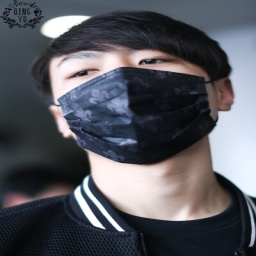

In [15]:
masked=list(data_dir.glob('with_mask/*'))
PIL.Image.open(str(masked[55]))

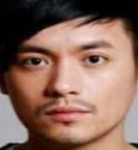

In [16]:
unmasked=list(data_dir.glob('without_mask/*'))
PIL.Image.open(str(unmasked[33]))

In [17]:
batch_size=32
img_height=180
img_width=180

In [18]:
train_datagen = ImageDataGenerator(
        #rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.15)

In [19]:
train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(180, 180),
        batch_size=32,
        class_mode='categorical',
        subset='training')

Found 9386 images belonging to 2 classes.


In [20]:
validation_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(180, 180),
        batch_size=32,
        class_mode='categorical',
        subset='validation')

Found 1656 images belonging to 2 classes.


In [21]:
class_names = train_generator.class_indices
print(class_names)

{'with_mask': 0, 'without_mask': 1}


In [22]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='tanh'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='tanh'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(2, activation='softmax')
])

In [23]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.003, momentum=0.23, nesterov=True)

In [24]:
class my_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss')<0.08):
            self.model.stop_training=True

In [25]:
callbacks=my_callback()

In [26]:
model.compile(optimizer='adam',
             loss=tf.losses.CategoricalCrossentropy(),
             metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [28]:
epochs=100

In [29]:
history=model.fit(
        train_generator,
        batch_size=110,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks=[callbacks]
        )

Epoch 1/100
294/294 [==============================] - 121s 401ms/step - loss: 0.2137 - accuracy: 0.9180 - val_loss: 0.1179 - val_accuracy: 0.9601
Epoch 2/100
294/294 [==============================] - 116s 394ms/step - loss: 0.1091 - accuracy: 0.9618 - val_loss: 0.0762 - val_accuracy: 0.9783


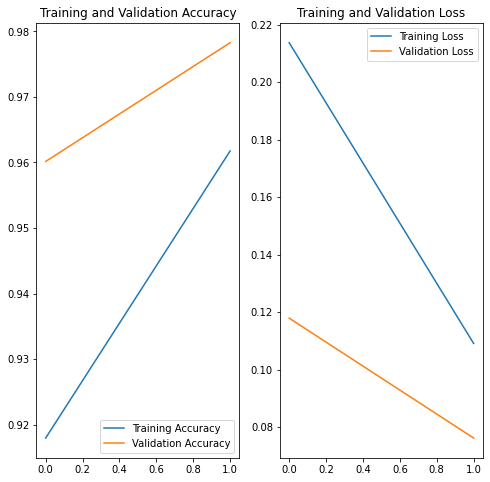

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['val_loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [31]:
from PIL import Image
import urllib
import requests

In [32]:
demodict = {#masked Swee Koon
            "https://i.imgur.com/rxnZiPc.png":"rxnZiPc.png",
            #unmasked Swee Koon
            "https://i.imgur.com/jyxNAgR.png":"jyxNAgR.png",
            #Masked Nayeon
            "https://i.pinimg.com/originals/e7/50/dc/e750dc18369e50a97df6bd8301d48121.jpg":"e750dc18369e50a97df6bd8301d48121.jpg",
            #Unmasked Nayeon
            "https://i.imgur.com/9d8mBye.png":"9d8mBye.png",
            #Unmasked South Asian Male
            "https://i.imgur.com/bitjnjH.png":"bitjnjH.png",
            #Unmasked European Female
            "https://i.imgur.com/RNrFsZ8.png":"RNrFsZ8.png",
            #Masked Bams
            "https://i.imgur.com/4HcGh4i.png":"4HcGh4i.png",
            #Unmasked Bams
            "https://i.imgur.com/U0OSRED.png":"U0OSRED.png",
            #Unmasked Bams 2
            "https://i.imgur.com/l0rotl6.png":"l0rotl6.png",
            #Unmasked Asian Male
            "https://i.imgur.com/vk1GjhU.png":"vk1GjhU.png",
            #Flesh-toned Masked Southeast Asian Female
            #"https://i.imgur.com/UvCXKKl.png":"UvCXKKl.png",
            #Improperly-masked Asian Female
            #"https://i.imgur.com/B2H5DW0.png":"B2H5DW0.png",
            #Facial-patterned Masked European Female
            "https://i.imgur.com/81Ovp18.png":"81Ovp18.png",
            #Facial-patterned Masked South American Male
            "https://i.imgur.com/mSdnJVM.png":"mSdnJVM.png"
            }

In [33]:
def demofunct(dictio):
    for key, value in dictio.items():
        test_url = key
        test_path = tf.keras.utils.get_file(value, origin=test_url)

        img = keras.preprocessing.image.load_img(
            test_path, target_size=(img_height, img_width)
        )
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch

        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])

        response = requests.get(test_url, stream=True)
        img = Image.open(response.raw)

        plt.imshow(img)
        plt.show()

        maskedodds=100*predictions[0][0]
        unmaskedodds=100*predictions[0][1]

        if predictions[0][0] > predictions[0][1]:
            print("MASKED, with ", round(maskedodds, 3),"% confidence")
        else:
            print("UNMASKED, with ", round(unmaskedodds, 3), "% confidence")

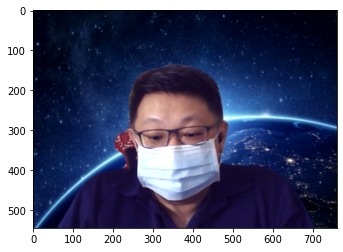

MASKED, with  99.238 % confidence


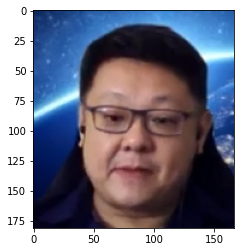

UNMASKED, with  99.385 % confidence


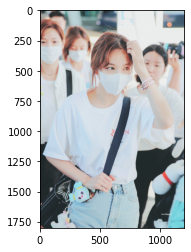

MASKED, with  99.879 % confidence


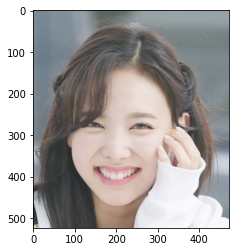

UNMASKED, with  75.124 % confidence


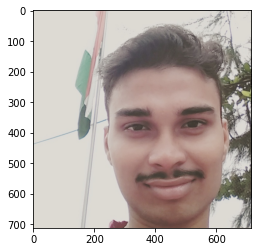

UNMASKED, with  74.066 % confidence


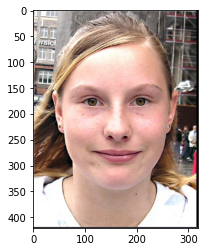

UNMASKED, with  99.382 % confidence


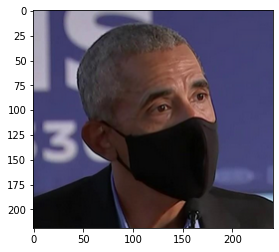

MASKED, with  97.562 % confidence


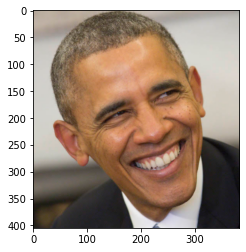

UNMASKED, with  90.603 % confidence


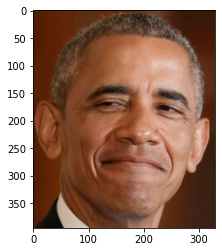

UNMASKED, with  99.096 % confidence


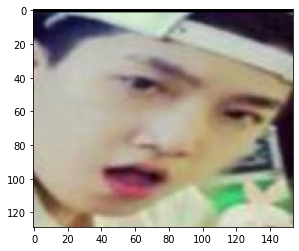

UNMASKED, with  96.417 % confidence


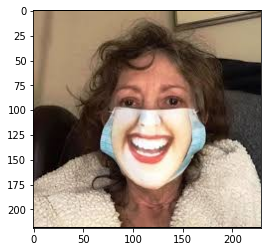

MASKED, with  99.003 % confidence


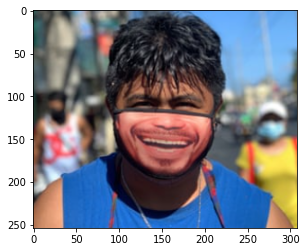

UNMASKED, with  82.935 % confidence


In [34]:
demofunct(demodict)

In [35]:
#Model saving - YOU MUST DOWNLOAD THIS OR SAVE IT TO GOOGLE DRIVE OR IT WILL BE LOST WHEN YOUR NOTEBOOK INSTANCE EXPIRES
model.save('kabamvision_module1_maskdet_cv',save_format='h5')